Fit Baker et al. data with linear-nonlinear model with signed ReLU function, using ridge regression on linear filter params.

$$r = \pm \left[\mathbf{h}^T\mathbf{x}\right]_+$$

Step 0: Fit linear filter only to stim period.

Step 1: Optimize filter under ReLU nonlin.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, signal, stats
from sklearn.linear_model import Ridge
import sys

from aux import make_dsn_mat
from disp import set_plot
from record_2_lin_ln import smlt_ln_relu

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

DUR_H = 10
IDUR_H = int(round(DUR_H/DT))

NNRN = 224
ALPHA = 100

FSAVE = 'data/simple/neur/baker_lnr_relu.npy'

In [2]:
# load data
DF_S = pd.read_csv('data/simple/neur/baker_resampled_s.csv')
DF_P = pd.read_csv('data/simple/neur/baker_resampled_p.csv')

I_S = np.array(DF_S['S'])
I_P = np.array(DF_P['P'])

R_SS = np.array(DF_S[[f'R_{cnrn}' for cnrn in range(NNRN)]])
R_PS = np.array(DF_P[[f'R_{cnrn}' for cnrn in range(NNRN)]])

T = np.arange(len(I_S))*DT

Step 0: Fit linear filters to during-stim epoch

In [3]:
nrns_fit = range(NNRN)

In [4]:
# loop over expt_ids
h_s_0s = np.nan*np.zeros((IDUR_H, NNRN))
h_p_0s = np.nan*np.zeros((IDUR_H, NNRN))

# initialize signs based on integrated sine and pulse responses
sgn_0s = np.sign(np.nanmean(R_SS[T < 10], 0) + np.nanmean(R_PS[T < 10], 0))

r_0_ss = np.nan*R_SS
r_0_ps = np.nan*R_PS

for cnrn, inrn in enumerate(nrns_fit):
    sys.stdout.write('.')
    r_s = R_SS[:, inrn]
    r_p = R_PS[:, inrn]
    
    mvalid_s = (~np.isnan(r_s)) & (T < 10)  # during-stim epoch
    mvalid_p = (~np.isnan(r_p)) & (T < 10)
    
    # fit model
    # build stim design matrix
    stim_mat_s = make_dsn_mat(I_S, IDUR_H)
    stim_mat_p = make_dsn_mat(I_P, IDUR_H)

    # get filter
    rgr_s = Ridge(alpha=ALPHA, fit_intercept=False).fit(stim_mat_s[mvalid_s, :], r_s[mvalid_s]/DT) 
    h_s = rgr_s.coef_[::-1]
    
    rgr_p = Ridge(alpha=ALPHA, fit_intercept=False).fit(stim_mat_p[mvalid_p, :], r_p[mvalid_p]/DT) 
    h_p = rgr_p.coef_[::-1]

    h_s_0s[:, inrn] = h_s
    h_p_0s[:, inrn] = h_p
    
params_0 = {'EXPT_ID': nrns_fit, 'H_SS': h_s_0s, 'H_PS': h_p_0s, 'SGNS': sgn_0s}

................................................................................................................................................................................................................................

# Examine Step-0 fits

In [5]:
r_smln_s_0s = smlt_ln_relu(I_S, 0*I_P, params_0, DT)
r_smln_p_0s = smlt_ln_relu(0*I_S, I_P, params_0, DT)

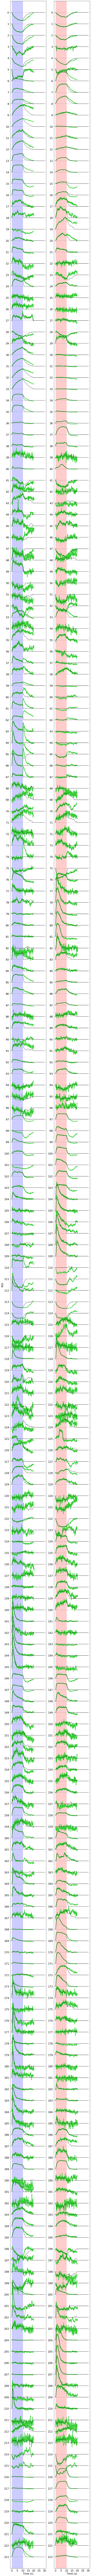

In [6]:
t = np.arange(len(R_SS))*DT

nplot = len(nrns_fit)
fig, axs = plt.subplots(1, 2, figsize=(8, nplot), tight_layout=True)
y_ticks = []

for cnrn, inrn in enumerate(nrns_fit):
    y_tick = -4*cnrn
    
    ## sine response
    axs[0].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[0].plot(t, R_SS[:, inrn] + y_tick, c='limegreen', lw=3)  # true
    axs[0].plot(t, r_smln_s_0s[:, inrn] + y_tick, c='k', lw=1)  # simulated 
    
    ## pulse response
    axs[1].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[1].plot(t, R_PS[:, inrn] + y_tick, c='limegreen', lw=3)
    axs[1].plot(t, r_smln_p_0s[:, inrn] + y_tick, c='k', lw=1)  # simulated
    
    y_ticks.append(y_tick)
    
axs[0].axvspan(0, 10, color='b', alpha=.2)
axs[1].axvspan(0, 10, color='r', alpha=.2)

axs[0].set_ylabel('ROI')

for ax in axs:
    set_plot(ax, y_lim=(-4*nplot, 4), y_ticks=y_ticks, y_tick_labels=nrns_fit, x_label='Time (s)', font_size=16)

Step 1: Optimize filter under ReLU nonlin

In [7]:
ignore_off_s = [60, 61, 62, 98, 101, 110, 162]
ignore_off_p = [62, 67, 74, 98, 146, 147]

silence_off_s = [57, 63, 64, 65, 66, 67, 74]

In [ ]:
ALPHA_2 = .1

def obj_under_relu(param, r_s, r_p, sgn):
    h_s = param[:len(param)//2]
    h_p = param[len(param)//2:]
    
    params_temp = {
        'H_SS': h_s[:, None], 'H_PS': h_p[:, None], 'SGNS': np.array([sgn])
    }
    
    r_smln_s = smlt_ln_relu(I_S, 0*I_P, params_temp, DT)[:, 0]
    r_smln_p = smlt_ln_relu(0*I_S, I_P, params_temp, DT)[:, 0]

    mse = np.nansum(cc([r_s-r_smln_s, r_p-r_smln_p])**2)
    return mse + ALPHA_2*np.linalg.norm(param)**2

## loop over neurons
h_s_1s = np.nan*h_s_0s
h_p_1s = np.nan*h_p_0s

for cnrn, inrn in enumerate(nrns_fit):
    sys.stdout.write('.')
    r_s = R_SS[:, inrn].copy()
    r_p = R_PS[:, inrn].copy()
    h_s_0 = h_s_0s[:, inrn]
    h_p_0 = h_p_0s[:, inrn]
    
    if inrn in ignore_off_s:
        r_s[10 <= T] = np.nan
    if inrn in silence_off_s:
        r_s[10 <= T] = 0
        
    if inrn in ignore_off_p:
        r_p[10 <= T] = np.nan
        
    sgn = sgn_0s[inrn]
    
    bounds = len(h_s_0)*[(None, None)] + len(h_p_0)*[(None, None)]
    
    np.random.seed(0)
    fit_rslt = optimize.minimize(
        obj_under_relu, x0=cc([h_s_0, h_p_0]), args=(r_s, r_p, sgn), bounds=bounds)
    
    h_s_1s[:, inrn] = fit_rslt.x[:len(h_s_0)]
    h_p_1s[:, inrn] = fit_rslt.x[len(h_p_0):]

..........................................................................................................................

In [ ]:
params_1 = {
    'EXPT_ID': range(NNRN), 'H_SS': h_s_1s, 'H_PS': h_p_1s, 'SGNS': sgn_0s
}

# Examine Step-1 fits

In [ ]:
r_smln_s_1s = smlt_ln_relu(I_S, 0*I_P, params_1, DT)
r_smln_p_1s = smlt_ln_relu(0*I_S, I_P, params_1, DT)

In [ ]:
t = np.arange(len(R_SS))*DT

nplot = len(nrns_fit)
fig, axs = plt.subplots(1, 2, figsize=(8, nplot), tight_layout=True)
y_ticks = []

for cnrn, inrn in enumerate(nrns_fit):
    y_tick = -4*cnrn
    
    ## sine response
    axs[0].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[0].plot(t, R_SS[:, inrn] + y_tick, c='limegreen', lw=3)  # true
    axs[0].plot(t, r_smln_s_0s[:, inrn] + y_tick, c='k', ls='--', lw=1)  # step 0
    axs[0].plot(t, r_smln_s_1s[:, inrn] + y_tick, c='k', lw=1)  # step 1
    
    ## pulse response
    axs[1].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[1].plot(t, R_PS[:, inrn] + y_tick, c='limegreen', lw=3)
    axs[1].plot(t, r_smln_p_0s[:, inrn] + y_tick, c='k', ls='--', lw=1)  # step 0
    axs[1].plot(t, r_smln_p_1s[:, inrn] + y_tick, c='k', lw=1)  # step 1
    
    y_ticks.append(y_tick)
    
axs[0].axvspan(0, 10, color='b', alpha=.2)
axs[1].axvspan(0, 10, color='r', alpha=.2)

axs[0].set_ylabel('ROI')

for ax in axs:
    set_plot(ax, y_lim=(-4*nplot, 1), y_ticks=y_ticks, y_tick_labels=nrns_fit, x_label='Time (s)', font_size=16)

In [ ]:
np.save(FSAVE, np.array([params_1]))